We use simple supervised learning models to prepare future values of predictors

In [ ]:
!pip install statsforecast mlforecast neuralforecast s3fs pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.6/154.6 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 16.6 MB/s et

In [17]:
# Laod libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsforecast import StatsForecast


from statsforecast.models import (
    SeasonalNaive,
    AutoARIMA,
    AutoETS
)


from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean
from category_encoders.ordinal import OrdinalEncoder


from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression


In [ ]:
# load data and remove unneccessary columns. Set date as the index

nurse_df = pd.read_csv('data/eng_workforce_master.csv')

nurse_tidy = nurse_df.drop(["org_name", "nhse_region_name", "ics_name", "id", "hc_lag2", "hc_lag3", "hc_lag4"], axis = 1)

nurse_tidy['date'] = nurse_tidy['date'].apply(pd.to_datetime)

# convert datetime to end-of-month

nurse_tidy = nurse_tidy.set_index("date")

nurse_tidy.index = nurse_tidy.index.to_period('M').to_timestamp('M')

nurse_tidy['covid_index'] = np.where(nurse_tidy['year'] == 2020, 1, 0)


In [29]:
# convert categorical features - for ML models

# Set up the ordinal encoder

o_enc = OrdinalEncoder()

o_enc.fit(nurse_tidy[["nhse_region_code"]])

nurse_tidy["nhse_region_code"] = o_enc.transform(nurse_tidy[["nhse_region_code"]])

In [31]:
nurse_df = nurse_tidy[nurse_tidy['year'] <= 2022]
nurse_df = nurse_df.reset_index()

test = nurse_tidy[nurse_tidy['year'] > 2022]

We use lgbm to estimate future values of predictors

In [21]:
# Fit models

horizon = 72

snaive = [
    SeasonalNaive(season_length=12)
]

In [22]:
# Instantiate the StatsForecast class

fit_snaive = StatsForecast(
    models=snaive,  # A list of models to be used for forecasting
    freq='M',  # The frequency of the time series data (in this case, 'D' stands for daily frequency)
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

In [23]:
org_code = nurse_df['org_code'].unique().tolist()

hc_leavers

In [32]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'hc_leavers' becomes 'y' representing the target variable we want to forecast


hc_leavers_df = nurse_df[['date', 'nhse_region_code', 'org_code', 'covid_index', 'hc_leavers']].copy()

hc_leavers_df = hc_leavers_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'hc_leavers': 'y'
})

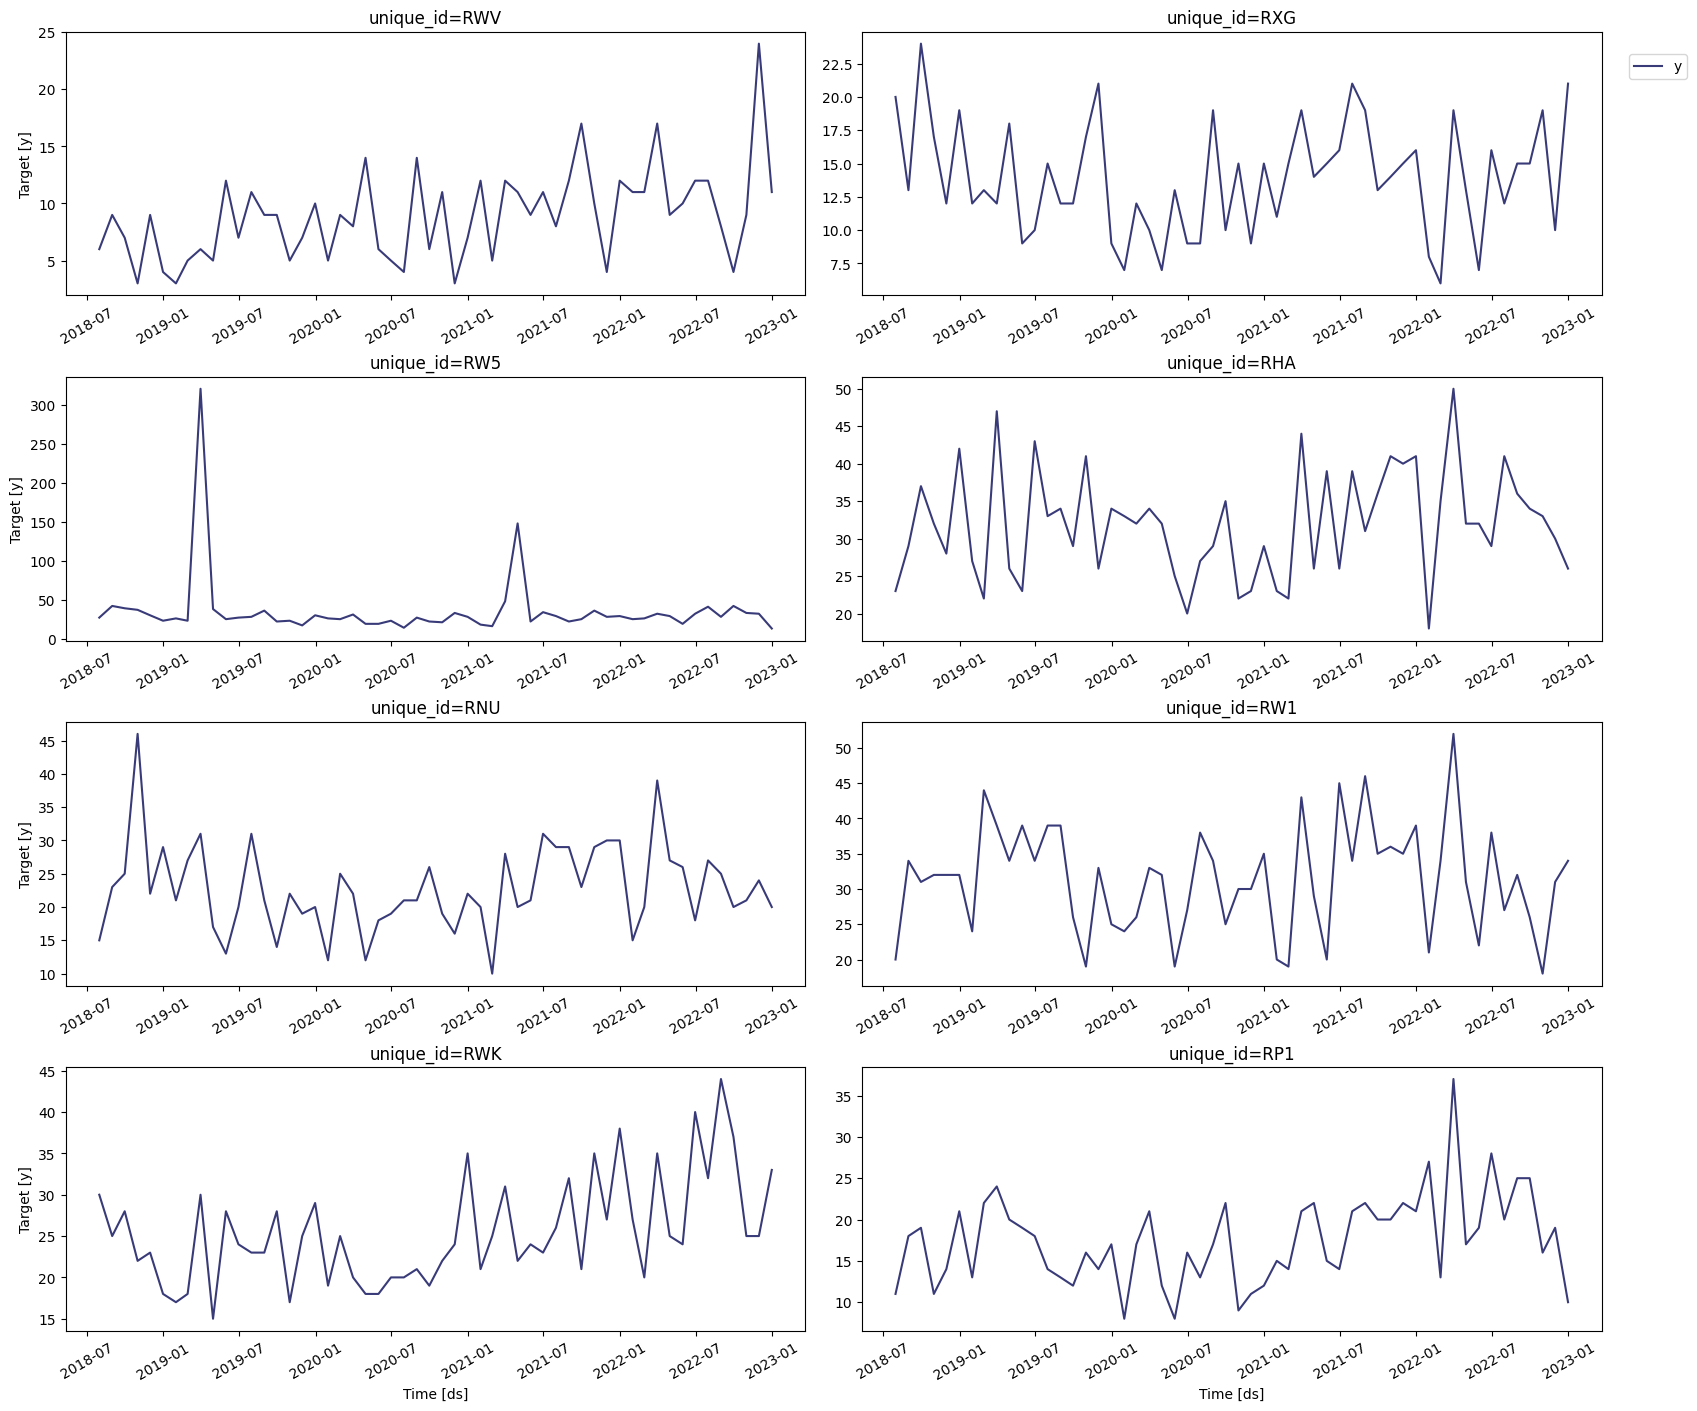

In [ ]:
# Feature: plot random series for EDA

StatsForecast.plot(hc_leavers_df)

In [37]:
# Instantiate the MLForecast object

mlf = MLForecast(
    models=[LGBMRegressor()],  # List of models for forecasting: LightGBM, XGBoost and Linear Regression
    freq='M',  # Frequency of the data - 'D' for daily frequency
    lags=[1],  # Specific lags to use as regressors: 1 to 6 days
    lag_transforms = {
        1:  [expanding_mean],  # Apply expanding mean transformation to the lag of 1 day
    },
    date_features=['year', 'month', 'quarter'],  # Date features to use as regressors
)


In [40]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(hc_leavers_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')

C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 19.039216
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 2385, number of used features: 7
[LightGBM] [Info] Start training from score 19.025157
MLForecast Minutes: 0.006033972899119059


In [41]:
fcst_hc_leavers_df = mlf.predict(72)
fcst_hc_leavers_df.rename(columns={'LGBMRegressor': 'hc_leavers'}, inplace=True)
fcst_hc_leavers_df

C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

,unique_id,ds,hc_leavers
0,R1L,2023-01-31,17.782311
1,R1L,2023-02-28,28.324477
2,R1L,2023-03-31,35.981066
3,R1L,2023-04-30,23.566663
4,R1L,2023-05-31,23.488047
...,...,...,...
3235,TAJ,2028-08-31,17.377779
3236,TAJ,2028-09-30,16.940630
3237,TAJ,2028-10-31,15.982670
3238,TAJ,2028-11-30,15.982670


hc_joinners

In [49]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'hc_joiners' becomes 'y' representing the target variable we want to forecast


hc_joiners_df = nurse_df[['date', 'org_code', 'hc_joiners', 'covid_index', 'nhse_region_code']].copy()

hc_joiners_df = hc_joiners_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'hc_joiners': 'y'
})

In [50]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(hc_joiners_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')

C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 19.460566
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 2385, number of used features: 7
[LightGBM] [Info] Start training from score 19.461216
MLForecast Minutes: 0.005956904093424479


In [51]:
fcst_hc_joiners_df = mlf.predict(72)
fcst_hc_joiners_df.rename(columns={'LGBMRegressor': 'hc_joiners'}, inplace=True)

C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

sickness_absence_rate_percent

In [52]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'sickness_absence_rate_percent' becomes 'y' representing the target variable we want to forecast


absence_rate_df = nurse_df[['date', 'org_code', 'sickness_absence_rate_percent', 'nhse_region_code', 'covid_index']].copy()

absence_rate_df = absence_rate_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'sickness_absence_rate_percent': 'y'
})

In [53]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(absence_rate_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')

C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 5.061159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 2385, number of used features: 7
[LightGBM] [Info] Start training from score 5.096587
MLForecast Minutes: 0.005707971254984538


In [54]:
fcst_absence_rate_df = mlf.predict(72)
fcst_absence_rate_df.rename(columns={'LGBMRegressor': 'sickness_absence_rate_percent'}, inplace=True)

C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

number_of_vacancies

In [55]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'number_of_vacancies' becomes 'y' representing the target variable we want to forecast

vacancies_df = nurse_df[['date', 'org_code', 'number_of_vacancies', 'nhse_region_code', 'covid_index']].copy()

vacancies_df = vacancies_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'number_of_vacancies': 'y'
})


In [56]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(vacancies_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 377
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 526.064635
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 2385, number of used features: 7
[LightGBM] [Info] Start training from score 531.857583
MLForecast Minutes: 0.0054279724756876625


In [57]:
fcst_vacancies_df = mlf.predict(72)
fcst_vacancies_df.rename(columns={'LGBMRegressor': 'number_of_vacancies'}, inplace=True)

C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

ccg_spend_on_mh_as_a_percent_of_ccg_base_allocations

In [58]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'ccg_spend_on_mh_as_a_percent_of_ccg_base_allocations' becomes 'y' representing the target variable we want to forecast

spend_df = nurse_df[['date', 'org_code', 'ccg_spend_on_mh_as_a_percent_of_ccg_base_allocations', 'nhse_region_code', 'covid_index']].copy()

spend_df = spend_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'ccg_spend_on_mh_as_a_percent_of_ccg_base_allocations': 'y'
})


In [ ]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(spend_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 86
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 0.140725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [ ]:
fcst_spend_df = mlf.predict(72)
fcst_spend_df.rename(columns={'LGBMRegressor': 'ccg_spend_on_mh_as_a_percent_of_ccg_base_allocations'}, inplace=True)

C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

,unique_id,ds,ccg_spend_on_mh_as_a_percent_of_ccg_base_allocations
0,R1L,2023-01-31,0.138
1,R1L,2023-02-28,0.138
2,R1L,2023-03-31,0.138
3,R1L,2023-04-30,0.138
4,R1L,2023-05-31,0.138
...,...,...,...
3235,TAJ,2028-08-31,0.138
3236,TAJ,2028-09-30,0.138
3237,TAJ,2028-10-31,0.138
3238,TAJ,2028-11-30,0.138


garduates_per_1000_inhabitants

In [65]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'garduates_per_1000_inhabitants' becomes 'y' representing the target variable we want to forecast

graduates_df = nurse_df[['date', 'org_code', 'garduates_per_1000_inhabitants', 'nhse_region_code', 'covid_index']].copy()

graduates_df = graduates_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'garduates_per_1000_inhabitants': 'y'
})


In [67]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(graduates_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 3.624608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [68]:
fcst_graduates_df = mlf.predict(72)
fcst_graduates_df.rename(columns={'LGBMRegressor': 'garduates_per_1000_inhabitants'}, inplace=True)

C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

MHS32

In [70]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'MHS32' becomes 'y' representing the target variable we want to forecast

MHS32_df = nurse_df[['date', 'org_code', 'MHS32', 'nhse_region_code', 'covid_index']].copy()

MHS32_df = MHS32_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'MHS32': 'y'
})


In [71]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(MHS32_df,
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 6273.095861
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 2385, number of used features: 7
[LightGBM] [Info] Start training from score 6285.167715
MLForecast Minutes: 0.005568122863769532


In [72]:
fcst_MHS32_df = mlf.predict(72, level=[99])
fcst_MHS32_df.rename(columns={'LGBMRegressor': 'MHS32', 'LGBMRegressor-lo-99': 'MHS32_low', 'LGBMRegressor-hi-99': 'MHS32_high',}, inplace=True)
fcst_MHS32_df

C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

,unique_id,ds,MHS32,MHS32_low,MHS32_high
0,R1L,2023-01-31,8109.805634,7380.144775,8839.466494
1,R1L,2023-02-28,8174.673956,7445.013097,8904.334815
2,R1L,2023-03-31,9198.687465,8469.026605,9928.348324
3,R1L,2023-04-30,8269.154349,7539.493490,8998.815209
4,R1L,2023-05-31,8839.168788,8109.507928,9568.829647
...,...,...,...,...,...
3235,TAJ,2028-08-31,5774.283097,3989.340626,7559.225567
3236,TAJ,2028-09-30,5785.053364,4000.110893,7569.995834
3237,TAJ,2028-10-31,6375.432288,4590.489818,8160.374759
3238,TAJ,2028-11-30,7531.657886,5746.715415,9316.600356


MHS01

In [74]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'MHS01' becomes 'y' representing the target variable we want to forecast

MHS01_df = nurse_df[['date', 'org_code', 'MHS01', 'nhse_region_code', 'covid_index']].copy()

MHS01_df = MHS01_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'MHS01': 'y'
})


In [75]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(MHS01_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 26236.877996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 2385, number of used features: 7
[LightGBM] [Info] Start training from score 26325.639413
MLForecast Minutes: 0.005622585614522298


In [76]:
fcst_MHS01_df = mlf.predict(72, level=[99])
fcst_MHS01_df.rename(columns={'LGBMRegressor': 'MHS01', 'LGBMRegressor-lo-99': 'MHS01_low', 'LGBMRegressor-hi-99': 'MHS01_high',}, inplace=True)


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

MHS07

In [78]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'MHS07' becomes 'y' representing the target variable we want to forecast

MHS07_df = nurse_df[['date', 'org_code', 'MHS07', 'nhse_region_code', 'covid_index']].copy()

MHS07_df = MHS07_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'MHS07': 'y'
})


In [79]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(MHS07_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 394.952070
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 2385, number of used features: 7
[LightGBM] [Info] Start training from score 394.362683
MLForecast Minutes: 0.0058388352394104


In [80]:
fcst_MHS07_df = mlf.predict(72, level=[99])
fcst_MHS07_df.rename(columns={'LGBMRegressor': 'MHS07', 'LGBMRegressor-lo-99': 'MHS07_low', 'LGBMRegressor-hi-99': 'MHS07_high',}, inplace=True)


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

MHS29

In [81]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'MHS29' becomes 'y' representing the target variable we want to forecast

MHS29_df = nurse_df[['date', 'org_code', 'MHS29', 'nhse_region_code', 'covid_index']].copy()

MHS29_df = MHS29_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'MHS29': 'y'
})


In [82]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(MHS29_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 42458.411765
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 544
[LightGBM] [Info] Number of data points in the train set: 2385, number of used features: 7
[LightGBM] [Info] Start training from score 42404.867925
MLForecast Minutes: 0.005431548754374186


In [83]:
fcst_MHS29_df = mlf.predict(72, level=[99])
fcst_MHS29_df.rename(columns={'LGBMRegressor': 'MHS29', 'LGBMRegressor-lo-99': 'MHS29_low', 'LGBMRegressor-hi-99': 'MHS29_high',}, inplace=True)


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

IFTN

In [85]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'IFTN' becomes 'y' representing the target variable we want to forecast

IFTN_df = nurse_df[['date', 'org_code', 'IFTN', 'nhse_region_code', 'covid_index']].copy()

IFTN_df = IFTN_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'IFTN': 'y'
})


In [86]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(IFTN_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 87
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 952.181358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [87]:
fcst_IFTN_df = mlf.predict(72)
fcst_IFTN_df.rename(columns={'LGBMRegressor': 'IFTN'}, inplace=True)


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

ucas_acceptance_rate

In [88]:
# Rename columns to match the Nixtlaverse's expectations
# The 'org_code' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'ucas_acceptance_rate' becomes 'y' representing the target variable we want to forecast

ucas_df = nurse_df[['date', 'org_code', 'ucas_acceptance_rate', 'nhse_region_code', 'covid_index']].copy()

ucas_df = ucas_df.rename(columns={
    'org_code': 'unique_id',
    'date': 'ds',
    'ucas_acceptance_rate': 'y'
})


In [89]:
# Start the timer to calculate the time taken for fitting the models
init = time()

# Fit the MLForecast models to the data, with prediction intervals set using a window size of 28 days
mlf.fit(ucas_df, 
static_features=['nhse_region_code', 'covid_index'],
prediction_intervals=PredictionIntervals())

# Calculate the end time after fitting the models
end = time()

# Print the time taken to fit the MLForecast models, in minutes
print(f'MLForecast Minutes: {(end - init) / 60}')


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 2295, number of used features: 7
[LightGBM] [Info] Start training from score 23.225868
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 2385, number of used features: 7
[LightGBM] [Info] Start training from score 23.638876
MLForecast Minutes: 0.005768044789632162


In [90]:
fcst_ucas_df = mlf.predict(72)
fcst_ucas_df.rename(columns={'LGBMRegressor': 'ucas_acceptance_rate'}, inplace=True)


C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
C:\Users\chama\AppData\Local\Programs\Python\Python310\lib\site-packages\utilsforecast\processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_o

In [91]:
## merge preddataframes together

eng_predictors = fcst_hc_leavers_df.merge(
    fcst_hc_joiners_df,how ='left',on=['unique_id', 'ds']).merge(
        fcst_absence_rate_df,how ='left',on=['unique_id', 'ds']).merge(
        fcst_vacancies_df,how ='left',on=['unique_id', 'ds']).merge(
        fcst_spend_df,how ='left',on=['unique_id', 'ds']).merge(
        fcst_MHS32_df,how ='left',on=['unique_id', 'ds']).merge(
        fcst_MHS01_df,how ='left',on=['unique_id', 'ds']).merge(
        fcst_MHS07_df,how ='left',on=['unique_id', 'ds']).merge(
        fcst_MHS29_df,how ='left',on=['unique_id', 'ds']).merge(
        fcst_IFTN_df,how ='left',on=['unique_id', 'ds']).merge(
        fcst_ucas_df,how ='left',on=['unique_id', 'ds'])

In [ ]:
## save the eng_predictors file

eng_predictors.to_csv("eng_predictors.csv", index=False)